# NVFlare federated learning demo
### Linear model training on tabular data from 4 sites
Classification of colorectal cancer subtypes

`Credit`: [NVFlare](https://github.com/NVIDIA/NVFlare) and [Guinney, J. *et al*. Nat Med 2015](https://pmc.ncbi.nlm.nih.gov/articles/PMC4636487/)

In [1]:
!pip install nvflare

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

## Download demo contents
This will create a folder `/content/nvflare-demo/`

In [3]:
!git clone https://github.com/cmb-chula/nvflare-demo

fatal: destination path 'nvflare-demo' already exists and is not an empty directory.


### Inspect the dataset
This is a tabular data with **62 input features** for **binary classification**

The first column contains the labels

In [4]:
sample = pd.read_csv('nvflare-demo/crc-data/site-1.csv', header = None, index_col = None)
sample.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0,7.729270,6.928018,6.633788,6.041397,6.950963,8.684821,5.134577,8.508230,3.480208,...,6.280928,6.798537,3.924898,5.283471,2.623721,2.233605,6.754443,7.579554,7.838440,5.390439
1,0,5.397587,8.324105,5.005596,7.991302,8.627842,4.734898,6.699195,5.888905,3.401603,...,8.732093,5.408872,4.613382,6.621574,2.948672,8.759757,4.254976,6.026481,2.986770,5.999563
2,1,5.264620,8.838521,4.420074,9.772504,8.983732,4.747629,3.973467,6.135856,3.144440,...,6.610814,6.677330,5.443725,7.321818,2.967111,3.124622,5.283698,5.963463,2.918988,5.877558
3,1,6.277481,8.457780,4.186907,8.586403,7.700403,4.764041,4.962359,6.298398,5.708358,...,7.458347,4.770952,4.368889,6.696689,2.617790,5.197786,7.143733,5.921535,2.890193,5.051819
4,1,5.880490,8.235210,4.555127,7.850447,9.140407,5.159758,4.215272,6.819101,3.125776,...,6.714896,6.060804,5.091390,8.378900,2.496618,2.348676,5.458667,5.970200,3.378744,4.500216


Columns headers are contained in separated files

In [5]:
header = pd.read_csv('nvflare-demo/crc-data/site-1_header.csv', header = 0, index_col = None)
header.head()

,label,FAP,SLC5A6,GFPT2,ASCL2,TSPAN6,CCDC80,DUSP4,EFEMP2,TRIM7,...,SERPINB1,SEMA5A,ANO7,VAV3,RAB27B,TCN1,MCUB,PLEKHO1,CLDN11,CAB39L


External test data are reserved in **_test.csv**

In [6]:
!ls nvflare-demo/crc-data

README.md	   site-1_test.csv    site-2_test.csv	 site-3_test.csv    site-4_test.csv
site-1.csv	   site-2.csv	      site-3.csv	 site-4.csv
site-1_header.csv  site-2_header.csv  site-3_header.csv  site-4_header.csv


## Execute a local FL job with 4 clients

In [7]:
!python nvflare-demo/sklearn-linear/sklearn_linear_job.py

2024-11-19 09:45:07,646 - SimulatorRunner - INFO - Create the Simulator Server.
2024-11-19 09:45:07,656 - CoreCell - INFO - server: creating listener on tcp://0:55013
2024-11-19 09:45:07,711 - CoreCell - INFO - server: created backbone external listener for tcp://0:55013
2024-11-19 09:45:07,711 - ConnectorManager - INFO - 39475: Try start_listener Listener resources: {'secure': False, 'host': 'localhost'}
2024-11-19 09:45:07,713 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00002 PASSIVE tcp://0:23609] is starting
2024-11-19 09:45:08,214 - CoreCell - INFO - server: created backbone internal listener for tcp://localhost:23609
2024-11-19 09:45:08,215 - nvflare.fuel.f3.sfm.conn_manager - INFO - Connector [CH00001 PASSIVE tcp://0:55013] is starting
2024-11-19 09:45:08,499 - nvflare.fuel.hci.server.hci - INFO - Starting Admin Server localhost on Port 50401
2024-11-19 09:45:08,499 - SimulatorRunner - INFO - Deploy the Apps.
2024-11-19 09:45:08,517 - SimulatorRunner - INFO - Create

## Final accuracy of the global FL model after 10 rounds
* site-1: 0.9375
* site-2: 0.9551
* site-3: 0.9857
* site-4: 0.9434

## Let's build some local models to compare
Use the same SGDClassifier configuration as the FL run

In [8]:
local_data = {}
local_model = {}
local_acc = {}

for i in range(1, 5):
    data = pd.read_csv('nvflare-demo/crc-data/site-' + str(i) + '.csv', header = None, index_col = None)
    scaler = StandardScaler().fit(data.iloc[:, 1:])
    X = scaler.transform(data.iloc[:, 1:])
    y = data.iloc[:, 0]
    local_data['site-' + str(i)] = (X, y)

    model = SGDClassifier(penalty = 'l2', random_state = 4649, loss = 'log_loss', eta0 = 1e-3,
                          fit_intercept = True, learning_rate = 'constant', max_iter = 10).fit(X, y)
    local_model['site-' + str(i)] = model

    test_data = pd.read_csv('nvflare-demo/crc-data/site-' + str(i) + '_test.csv', header = None, index_col = None)
    X_test = scaler.transform(test_data.iloc[:, 1:])
    y_test = test_data.iloc[:, 0]
    local_acc['site-' + str(i)] = accuracy_score(y_test, model.predict(X_test))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## Accuracy on local site's data

In [9]:
local_acc

{'site-1': 0.9701492537313433,
 'site-2': 0.975975975975976,
 'site-3': 0.9533333333333334,
 'site-4': 0.9210526315789473}

## Performance of local models on other sites

In [10]:
sites = ['site-' + str(i) for i in range(1, 5)]
cross_site_acc = pd.DataFrame(0.0, index = sites, columns = sites)

for s1 in sites:
    cross_site_acc.loc[s1, s1] = local_acc[s1]

    for s2 in sites:
        if not s1 == s2:
            model = local_model[s1]
            X_test, y_test = local_data[s2]
            cross_site_acc.loc[s1, s2] = accuracy_score(y_test, model.predict(X_test))

Append accuracy from FL

In [11]:
cross_site_acc.loc['FL'] = [0.9375, 0.9551, 0.9857, 0.9434]
cross_site_acc.head(10)

,site-1,site-2,site-3,site-4
site-1,0.970149,0.957474,0.956897,0.920755
site-2,0.955128,0.975976,0.971264,0.939623
site-3,0.948718,0.961340,0.953333,0.913208
site-4,0.961538,0.962629,0.965517,0.921053
FL,0.937500,0.955100,0.985700,0.943400


## FL achieves a more balanced performance profile
Improve performances of site-3 and site-4 compared to local model

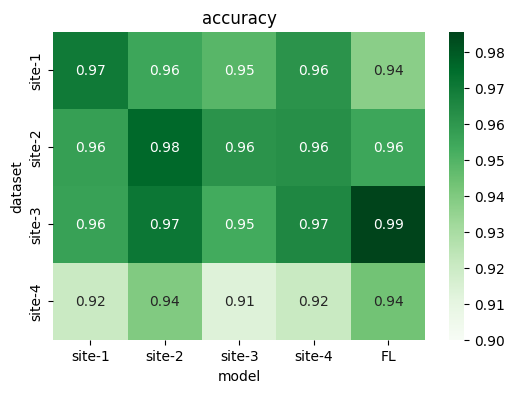

In [12]:
plt.figure(figsize = (6, 4))
sns.heatmap(data = cross_site_acc.T, cmap = plt.cm.Greens, annot = True, vmin = 0.90)
plt.xlabel('model'); plt.ylabel('dataset')
plt.title('accuracy')
plt.show()

### site-2's model performs very well because it has the largest amount of data

In [13]:
for s in sites:
    print(s, 'number of data points:', len(local_data[s][1]))

site-1 number of data points: 156
site-2 number of data points: 776
site-3 number of data points: 348
site-4 number of data points: 265
